In [1]:
from our_utils import *
from noisy_causal_discovery import *

from cdt.data import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import laplace
from sklearn.preprocessing import normalize
import sempler
from sempler.generators import dag_avg_deg
from tqdm.notebook import tqdm

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
''' Load the dataset and the graph and convert to correct format. Then add edges.
    Indices represent: 0: displacement, 1: mpg, 2: horsepower, 3: weight, 4: acceleration
    Finally, normalize the data.'''

raw_data, _ = load_dataset('tuebingen')
np_raw_data = raw_data.to_numpy()

np_raw_subdata = np.hstack((np_raw_data[12][0].reshape(-1, 1), np_raw_data[12][1].reshape(-1, 1))) # (0->1)
np_raw_subdata = np.hstack((np_raw_subdata, np_raw_data[13][0].reshape(-1, 1)))                    # (2->0)
np_raw_subdata = np.hstack((np_raw_subdata, np_raw_data[14][0].reshape(-1, 1)))                    # (3->0)
np_raw_subdata = np.hstack((np_raw_subdata, np_raw_data[15][1].reshape(-1, 1)))                    # (2->4)

n_full, d = np_raw_subdata.shape # get experiment dimesnions

G = np.zeros((d,d)) # put graph into numpy format
G[0,1] = 1 
G[2,0] = 1 
G[3,0] = 1 
G[2,4] = 1

nr_edges = np.sum(G) # get number of edges

data_full = np.zeros((n_full, d))
for j in range(d): # normalize
    data_full[:, j] = (np_raw_subdata[:, j].copy() - np.mean(np_raw_subdata[:, j])) / np.std(np_raw_subdata[:, j])

In [3]:
''' Choose general experiment parameters. '''

trials = 100          # no. of trials to average over
err_lvl = 0.05        # signficance level
delta = 0.25          # delta Huber parameter
no_graphs = 10        # number of graph variations
n = 100               # sample sized to be used in experiments
p_add = 2/(d*d)       # prob. of adding edge
p_remove = 2/nr_edges # prob. of removing edge

split_choices = [0.05, 0.5, 0.95] # splitting baselines

eps_choices = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] # privacy parameters

split_shd, noisy_shd = {}, {}        # initialize the SHD results dictionaries
split_widths, noisy_widths = {}, {}  # initialize the CI widths results dictionaries

In [4]:
''' Compute the splitting baselines SHD to graph selected by the full data
    and the estimated mean interval width. '''

for split in split_choices:

    split_shd[(split, delta)] = []
    split_widths[(split, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        idxs = np.random.choice(range(n_full), size=n, replace=False)
        data = data_full[idxs]

        G_options = generate_graphs(G, no_graphs, p_remove, p_add)

        full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
        full_G_est = G_options[np.argmin(full_scores)]

        select_data, infer_data = subsample(data, split)

        split_scores = [score(select_data, G_options[j], delta=delta) for j in range(no_graphs)]
        split_G_est = G_options[np.argmin(split_scores)]

        split_shd[(split, delta)].append(np.sum(np.abs(split_G_est - full_G_est)))

        if np.any(split_G_est) > 0:
            split_widths[(split, delta)].append(get_CI_width(infer_data, split_G_est, err_lvl))
        else:
            split_widths[(split, delta)].append(0)
    
    print("For split =", split,"data-splitting attains avg. SHD:", \
          np.round(np.mean(split_shd[(split, delta)]), 2))

    print("For split =", split,"data-splitting attains avg. CI widths:", \
          np.round(np.mean(split_widths[(split, delta)]), 2))
    
    print("------------------------------------------------------------")

  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.05 data-splitting attains avg. SHD: 4.65
For split = 0.05 data-splitting attains avg. CI widths: 0.23
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.5 data-splitting attains avg. SHD: 0.72
For split = 0.5 data-splitting attains avg. CI widths: 0.4
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.95 data-splitting attains avg. SHD: 0.03
For split = 0.95 data-splitting attains avg. CI widths: 0.76
------------------------------------------------------------


In [5]:
''' Compute the noisy-select SHD to graph selected by the full data
    and the estimated mean interval width for varying settings of epsilon. '''

for eps in eps_choices:
    
    err_lvl_adj = alpha_tilde(err_lvl, eps, n)

    noisy_shd[(eps, delta)] = []
    noisy_widths[(eps, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        idxs = np.random.choice(range(n_full), size=n, replace=False)
        data = data_full[idxs]

        G_options = generate_graphs(G, no_graphs, p_remove, p_add)

        full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
        full_G_est = G_options[np.argmin(full_scores)]

        sensitivity = get_sensitivity(data, G_options, delta=delta)
        noise_lvl = noise_scale(eps, sensitivity)

        noisy_scores = [score(data, G_options[j], delta) + laplace(scale=noise_lvl) for j in range(no_graphs)]
        noisy_G_est = G_options[np.argmin(noisy_scores)]

        noisy_shd[(eps, delta)].append(np.sum(np.abs(noisy_G_est - full_G_est)))

        if np.any(noisy_G_est):
            noisy_widths[(eps, delta)].append(get_CI_width(data, noisy_G_est, err_lvl_adj))
        else:
            noisy_widths[(eps, delta)].append(0)
            
    print("For eps =", eps,"noisy-select attins avg. SHD:", \
          np.round(np.mean(noisy_shd[(eps, delta)]), 2))

    print("For eps =", eps, "noisy-select attains avg. CI widths:", \
          np.round(np.mean(noisy_widths[(eps, delta)]), 2))

    print("------------------------------------------------------------")

  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.01 noisy-select attins avg. SHD: 4.52
For eps = 0.01 noisy-select attains avg. CI widths: 0.27
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.02 noisy-select attins avg. SHD: 4.12
For eps = 0.02 noisy-select attains avg. CI widths: 0.28
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.03 noisy-select attins avg. SHD: 3.82
For eps = 0.03 noisy-select attains avg. CI widths: 0.29
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.04 noisy-select attins avg. SHD: 3.49
For eps = 0.04 noisy-select attains avg. CI widths: 0.3
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.05 noisy-select attins avg. SHD: 3.27
For eps = 0.05 noisy-select attains avg. CI widths: 0.32
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.06 noisy-select attins avg. SHD: 3.1
For eps = 0.06 noisy-select attains avg. CI widths: 0.33
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.07 noisy-select attins avg. SHD: 2.72
For eps = 0.07 noisy-select attains avg. CI widths: 0.35
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.08 noisy-select attins avg. SHD: 2.4
For eps = 0.08 noisy-select attains avg. CI widths: 0.36
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.09 noisy-select attins avg. SHD: 2.39
For eps = 0.09 noisy-select attains avg. CI widths: 0.38
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.1 noisy-select attins avg. SHD: 2.29
For eps = 0.1 noisy-select attains avg. CI widths: 0.38
------------------------------------------------------------


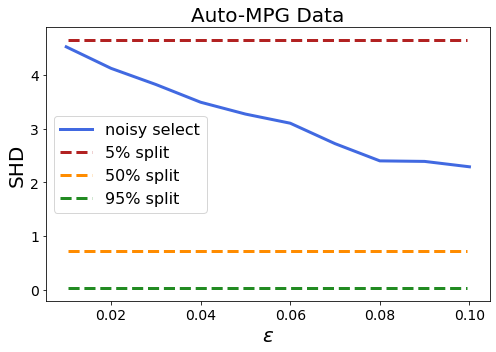

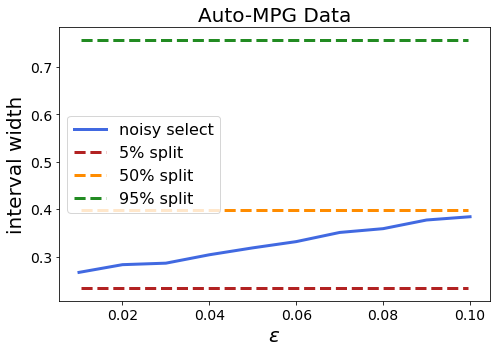

In [6]:
''' Plot the corresponding results. '''

colors=['firebrick', 'darkorange', 'forestgreen']

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_shd[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy select")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_shd[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("SHD", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=6)
plt.title("Auto-MPG Data", fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_widths[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy select")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_widths[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("interval width", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=6)
plt.title("Auto-MPG Data", fontsize=20)
plt.tight_layout()
plt.show()

In [7]:
''' [EXTRA] See SHD to *true* graph for full data. '''

full_shd = []
for trial in range(trials):
    np.random.seed(trial)

    idxs = np.random.choice(range(n_full), size=n, replace=False)
    data = data_full[idxs]

    G_options = generate_graphs(G, no_graphs, p_remove, p_add)

    full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
    full_G_est = G_options[np.argmin(full_scores)]

    full_shd.append(np.sum(np.abs(G - full_G_est)))
    
print(f"The shd to the *true* graph using the full data for selection is: {np.round(np.mean(full_shd), 2)}")

The shd to the *true* graph using the full data for selection is: 3.58
